# 1. Import data 
## 1.1. Import libraries

In [36]:
!unzip downscaled_images_raw.zip
!unzip downscaled_images_structure.zip

!unzip ResNet_Children_feature_product_ids.npy.zip
!unzip ResNet_Children_features.npy.zip
!unzip ResNet_Divided_feature_product_ids.npy.zip
!unzip ResNet_Divided_features.npy.zip
!unzip ResNet_Ladieswear_feature_product_ids.npy
!unzip ResNet_Ladieswear_features.npy.zip
!unzip ResNet_Menswear_feature_product_ids.npy.zip
!unzip ResNet_Menswear_features.npy.zip
!unzip ResNet_Sport_feature_product_ids.npy.zip
!unzip ResNet_Sport_features.npy.zip

In [37]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow import keras
from PIL import Image
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
%matplotlib inline


## 1.2. Import CSV file


In [38]:
# Load the dataset into a Pandas dataframe
df = pd.read_csv('dataset.csv')

# Make 2 copy of current dataframe for each approach
df_cb = df.copy()
df_dl = df.copy()

mini_df = df[(df['article_id'] >= 290000000) & (df['article_id'] < 520000000)]

# 1.3. General Data description

In [39]:
# Check for null values
df.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [40]:
# Check for dataframe columns type
mini_df.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [41]:
mini_df["index_group_name"].replace({"Baby/Children": "Children"}, inplace=True)
mini_df.value_counts("index_group_name")

/var/folders/8h/8019_k7n2hbf347dp2qkqff40000gn/T/ipykernel_20090/875143675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["index_group_name"].replace({"Baby/Children": "Children"}, inplace=True)


index_group_name
Children      2281
Ladieswear    2128
Menswear      1379
Divided       1217
Sport          400
dtype: int64

In [42]:
mini_df.shape

(7405, 25)

This table contains all h&m articles with details such as a type of product, a color, a product group and other features.
Article data description:

- __article_id__ : A unique identifier of every article.
- __product_code__, __prod_name__ : A unique identifier of every product and its name (not the same).
- __product_type__, __product_type_name__ : The group of product_code and its name
- __graphical_appearance_no__, __graphical_appearance_name__ : The group of graphics and its name
- __colour_group_code__, __colour_group_name__ : The group of color and its name
- __perceived_colour_value_id__, __perceived_colour_value_name__, __perceived_colour_master_id__, __perceived_colour_master_name__ : The added color info
- __department_no__, __department_name__: : A unique identifier of every dep and its name
- __index_code__, __index_name__: : A unique identifier of every index and its name
- __index_group_no__, __index_group_name__: : A group of indeces and its name
- __section_no__, __section_name__: : A unique identifier of every section and its name
- __garment_group_no__, __garment_group_name__: : A unique identifier of every garment and its name
- __detail_desc__: : Details

# 2. Data Cleaning

## Check article with no images

In [43]:
mini_df.duplicated().any() 

False

The dataset does not contain any duplicated rows.

In [44]:
# image downscale
import os
import cv2

# Set the input directory
input_dir = 'images/'

# # Get a list of the images in the input directory
image_folders = os.listdir(input_dir)
image_names = []

# # Iterate over the images
for folder in image_folders:
    # Load the image
    image_filenames = os.listdir(input_dir+folder)
    for filename in image_filenames:
        image_names.append(int(filename[0:10]))

print("Number of images: " + str(len(image_names)))
print("Number of samples: " + str(mini_df.shape[0]))


Number of images: 7324
Number of samples: 7405


<p>There is an inconsistent between the number of articles and the number of images even though they are sampled in groups. To be specific, number of images are <b style="color: #CB1C8D">81 item less</b> than the row count of article.csv. This implies that some are products in <b style="color: #CB1C8D">article.csv</b> do not have images associated with them.</p>

We will drop these records as to some extent, they are rows with NaN values.

In [45]:
# get a list of article ids in dataframe
ids = mini_df["article_id"].to_list()

article_without_images = []

for id in ids:
    if (id not in image_names):
        article_without_images.append(id)

print(article_without_images)

[324963030, 348657006, 357792006, 364409037, 369423002, 369423004, 388916001, 395864048, 396135047, 396135048, 396690010, 397376010, 398947001, 405310006, 408875001, 408875002, 408875010, 411565004, 419634007, 419634010, 419634013, 420264002, 425683012, 438702006, 442786001, 443262014, 446224011, 446224013, 453065011, 460363012, 461414009, 461414010, 468666002, 469039021, 469658014, 470985008, 470985010, 475791011, 475827007, 480076004, 481777003, 481797022, 481797026, 481797027, 484864002, 485673022, 485678030, 485678032, 485973011, 486639004, 487926002, 489758004, 490275001, 490473012, 491912034, 494030013, 496762004, 499802028, 504152001, 504152008, 504960001, 504960003, 506177002, 507399003, 508931033, 510415003, 510504001, 511653001, 512300003, 512964002, 513701002, 515074002, 516550001, 516898002, 517724002, 517729011, 517729015, 517729030, 519219008, 519815003, 519987002]


In [46]:
mini_df = mini_df[~mini_df["article_id"].isin(article_without_images)]

mini_df.shape

(7324, 25)

The number of samples and images are now equal to each other.

## Resize and structure images into correct folder

In [47]:
# # image downscale
# import os
# import cv2

# # Set the input directory
# input_dir = 'downscaled_images_raw/'

# # Set the output directory
# output_dir = 'downscaled_images_structure/'

# # # Get a list of the images in the input directory
# image_folders = os.listdir(input_dir)

# # # Iterate over the images
# for folder in image_folders:
#     image_filenames = os.listdir(input_dir+folder)
#     for filename in image_filenames:
#         # Load the image
#         image = cv2.imread(input_dir + folder + "/" + filename)

#         folder_name = mini_df[mini_df['article_id'] == int(
#             filename[0:10])]["index_group_name"].values[0]
#         # Downscale the image using linear interpolation
#         downscaled_image = cv2.resize(
#             image, (224, 224), interpolation=cv2.INTER_LINEAR)
#         # Save the downscaled image to a file
#         cv2.imwrite(output_dir+folder_name+"/" +
#                     "Images/" + filename, downscaled_image)


# 3. Recommender systems

## Approach 1: Content-based

### Feature Engineeering

In [48]:

# # top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# train_data_groups = ["Children", "Divided",
#                      "Ladieswear", "Menswear", "Sport"]

# epochs = 50
# batch_size = 1


# def extract_features(group):
#     Itemcodes = []
#     model = applications.ResNet50(
#         include_top=False, weights='imagenet')
#     datagen = ImageDataGenerator(rescale=1. / 255)

#     dir_path = "downscaled_images_structure/"+group+'/'
#     generator = datagen.flow_from_directory(
#         dir_path,
#         target_size=(224, 224),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)
#     for i in generator.filenames:
#         Itemcodes.append(i[(i.find("/")+1):i.find(".")])
#     extracted_features = model.predict(
#         generator, len(generator.filenames) // batch_size)

#     extracted_features = extracted_features.reshape(
#         (len(generator.filenames), 100352))

#     np.save(open('./ResNet_%s_features.npy' % group, 'wb'), extracted_features)
#     np.save(open('./ResNet_%s_feature_product_ids.npy' % group, 'wb'),
#             np.array(Itemcodes))


# for image_group in train_data_groups:
#     extract_features(image_group)


In [49]:
children_extracted_features = np.load('ResNet_Children_features.npy')
children_Productids = np.load('ResNet_Children_feature_product_ids.npy')
divided_extracted_features = np.load(
    './ResNet_Divided_features.npy')
divided_Productids = np.load('./ResNet_Divided_feature_product_ids.npy')
menswear_extracted_features = np.load(
    './ResNet_Menswear_features.npy')
menswear_Productids = np.load(
    './ResNet_Menswear_feature_product_ids.npy')
ladieswear_extracted_features = np.load(
    './ResNet_Ladieswear_features.npy')
ladieswear_Productids = np.load(
    './ResNet_Ladieswear_feature_product_ids.npy')
sport_extracted_features = np.load('./ResNet_Sport_features.npy')
sport_Productids = np.load(
    './ResNet_Sport_feature_product_ids.npy')


In [52]:
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances


def get_similar_products_cnn(product_id, num_results):
    if (mini_df[mini_df['article_id'] == int(product_id)].empty):
        print(mini_df[mini_df['article_id'] == int(product_id)])
        return "No item matched input Id"
    if (mini_df[mini_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Children"):
        extracted_features = children_extracted_features
        Productids = children_Productids
    elif (mini_df[mini_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Divided"):
        extracted_features = divided_extracted_features
        Productids = divided_Productids
    elif (mini_df[mini_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Menswear"):
        extracted_features = menswear_extracted_features
        Productids = menswear_Productids
    elif (mini_df[mini_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Ladieswear"):
        extracted_features = ladieswear_extracted_features
        Productids = ladieswear_Productids
    else:
        extracted_features = sport_extracted_features
        Productids = sport_Productids

    Productids = list(Productids)

    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(
        extracted_features, extracted_features[doc_id].reshape(1, -1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product details", "="*20)
    ip_row = mini_df[mini_df['article_id'] == int(Productids[indices[0]])]

    img = Image.open("downscaled_images_structure/" +
                     ip_row['index_group_name'].values[0]+"/Images/" + "0"+str(ip_row["article_id"].values[0])+".jpg")
    display(img)

    print('Product Title: ', ip_row['prod_name'])
    print("\n", "="*20, "Recommended products", "="*20)
    for i in range(1, len(indices)):
        rows = mini_df[mini_df['article_id'] == int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            img = Image.open("downscaled_images_structure/" +
                             row['index_group_name'] +
                             "/Images/0" + str(row["article_id"])+".jpg")
            display(img)
            print('Product Title: ', row['prod_name'])
            print('Euclidean Distance from input image:', pdists[i])


==================== input product details ====================


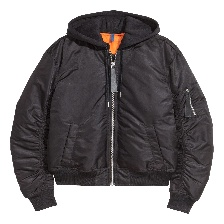

Product Title:  983    Hype
Name: prod_name, dtype: object

 ==================== Recommended products ====================


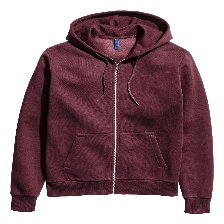

Product Title:  Hood W Zip
Euclidean Distance from input image: 34.82672


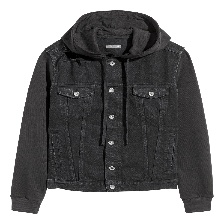

Product Title:  Denim hood mk6
Euclidean Distance from input image: 36.430397


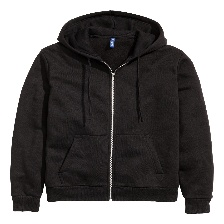

Product Title:  Hood W Zip
Euclidean Distance from input image: 39.15087


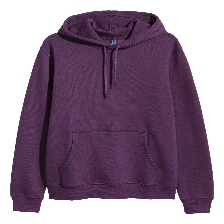

Product Title:  Richie Regular Hood
Euclidean Distance from input image: 40.589725


In [59]:
get_similar_products_cnn('0307952006', 5)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


le = preprocessing.LabelEncoder()


extracted_features = np.load('ResNet_features.npy')
le.fit(mini_df[mini_df["index_group_name"] == "Children"]["colour_group_name"])
labels = le.transform(
    mini_df[mini_df["index_group_name"] == "Children"]["colour_group_name"])

labels 


X_train, X_test, y_train, y_test = train_test_split(
    extracted_features, labels, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

recommendations = knn.predict(X_test)

# mini_df[mini_df["index_group_name"] == "Children"]


ValueError: Found input variables with inconsistent numbers of samples: [2268, 2281]

**Approach 2: Deep Learning**

### Encoding categorical value

### Embedding

In [ ]:
article_ids = df["article_id"].tolist()

tokenizer = Tokenizer(num_words=vocab_size)
sequences = tokenizer.texts_to_sequences(prod_names)

# Create an embedding matrix with random weights
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Define the model
model = Sequential()

# Add an embedding layer with the specified weights
prod_name_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])(sequences)

NameError: name 'vocab_size' is not defined